In [623]:
import sklearn
import sklearn.preprocessing
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import GaussianNoise
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

%matplotlib inline
from pandas.plotting import scatter_matrix
matplotlib.rcParams['figure.figsize'] = (10, 6)

### Dataset Cleaning and reformat

In [624]:
data = pd.read_csv('data/PRSA_data_2010.1.1-2014.12.31.csv')
data.head(10)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
5,6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
6,7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
7,8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
8,9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0
9,10,2010,1,1,9,NaN,-20,-8.0,1017.0,NW,27.28,0,0


In [625]:
data["timestamp"] = pd.to_datetime(data[["year", "month", "day", "hour"]])

In [626]:
data.drop(["No"], axis=1, inplace=True) 

In [627]:
data = data.set_index("timestamp")

In [628]:
# New index dataset
data.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,,,,,
2010-01-01 00:00:00,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [629]:
# Shape
print(data.shape)

(43824, 12)


In [630]:
# Drop rows with NAN value 
data = data.dropna()
data.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,2010,1,2,5,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,2010,1,2,6,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,2010,1,2,7,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,2010,1,2,8,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [631]:
# Shape
print(data.shape)

(41757, 12)


In [632]:
# Factorize String data
data.loc[:, 'cbwd'] = pd.factorize(data.loc[:, 'cbwd'])[0]
data.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,0,1.79,0,0
2010-01-02 01:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,0,2.68,0,0
2010-01-02 02:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,0,3.57,0,0
2010-01-02 03:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,0,5.36,1,0
2010-01-02 04:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,0,6.25,2,0
2010-01-02 05:00:00,2010,1,2,5,109.0,-7,-6.0,1022.0,0,7.14,3,0
2010-01-02 06:00:00,2010,1,2,6,105.0,-7,-6.0,1023.0,0,8.93,4,0
2010-01-02 07:00:00,2010,1,2,7,124.0,-7,-5.0,1024.0,0,10.72,0,0
2010-01-02 08:00:00,2010,1,2,8,120.0,-8,-6.0,1024.0,0,12.51,0,0


In [633]:
# Saved cleaned data
data.to_csv('data/cleaned_data')

### Data Static Summary

In [634]:
print(data.describe())

               year         month           day          hour         pm2.5  \
count  41757.000000  41757.000000  41757.000000  41757.000000  41757.000000   
mean    2012.042771      6.513758     15.685514     11.502311     98.613215   
std        1.415311      3.454199      8.785539      6.924848     92.050387   
min     2010.000000      1.000000      1.000000      0.000000      0.000000   
25%     2011.000000      4.000000      8.000000      5.000000     29.000000   
50%     2012.000000      7.000000     16.000000     12.000000     72.000000   
75%     2013.000000     10.000000     23.000000     18.000000    137.000000   
max     2014.000000     12.000000     31.000000     23.000000    994.000000   

               DEWP          TEMP          PRES          cbwd           Iws  \
count  41757.000000  41757.000000  41757.000000  41757.000000  41757.000000   
mean       1.750174     12.401561   1016.442896      1.201715     23.866747   
std       14.433658     12.175215     10.300733    

### Dataset Visualization

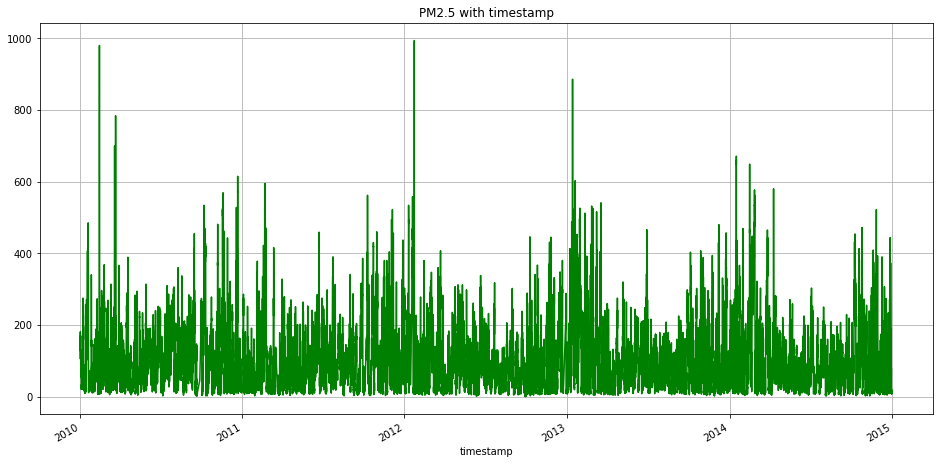

In [635]:
# Show how data looks like
plt.figure(figsize=[16, 8])
data['pm2.5'].plot(kind='line',color='green',grid=True)
plt.title("PM2.5 with timestamp");

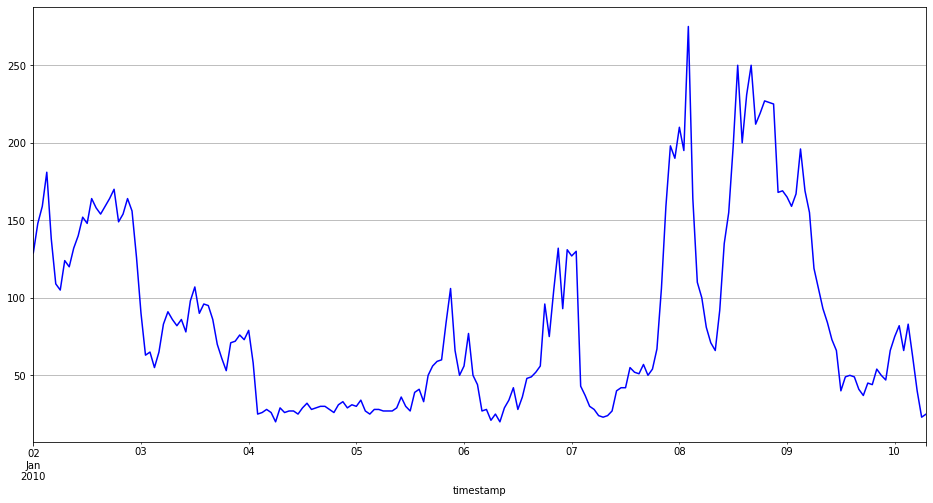

In [636]:
# Show one month zoom in pm2.5 data
plt.figure(figsize=[16, 8])
data['pm2.5'][:200].plot(kind='line',color='blue',grid=True);

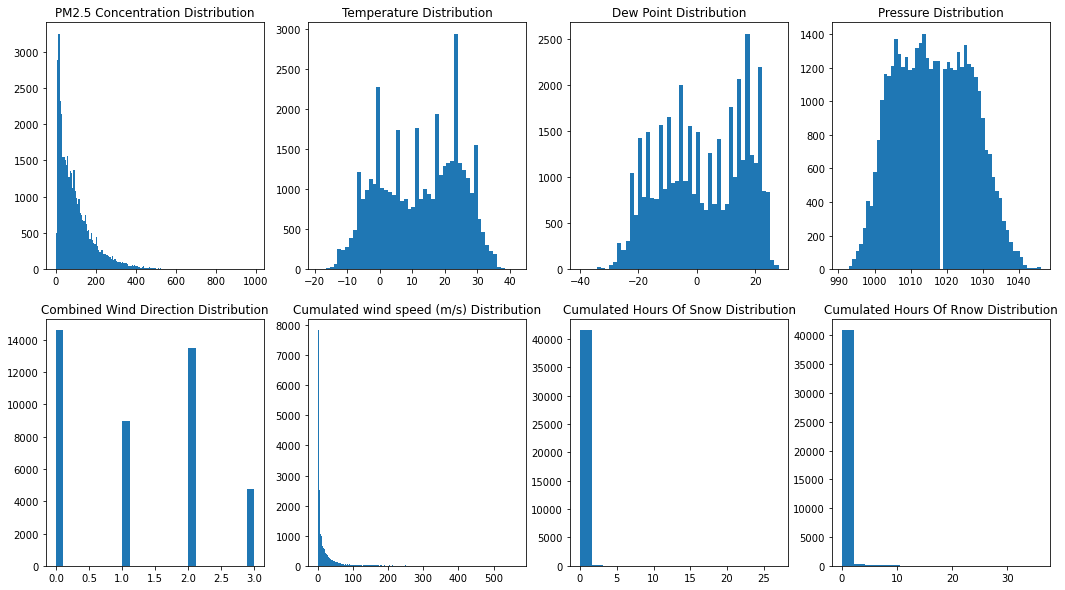

In [637]:
# plot the data distribution
content_list = ['pm2.5', 'TEMP', 'DEWP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']
title_list = ['PM2.5 Concentration Distribution', 'Temperature Distribution', 'Dew Point Distribution', \
             'Pressure Distribution', 'Combined Wind Direction Distribution', 'Cumulated wind speed (m/s) Distribution', \
             'Cumulated Hours Of Snow Distribution', 'Cumulated Hours Of Rnow Distribution']

plt.figure(figsize=(18,10))
for i in range(len(content_list)):
    plt.subplot(2, 4, i+1)
    plt.hist(data[content_list[i]], bins='auto')
    plt.title(title_list[i])

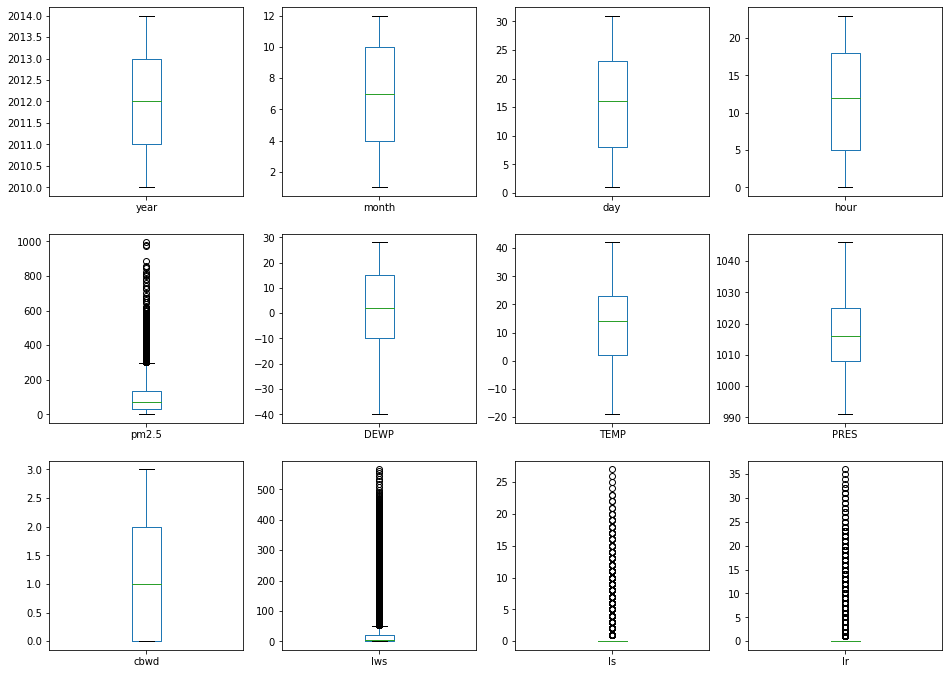

In [638]:
# Univariate plot
data.plot(kind='box', subplots=True, layout=(4,4), figsize=[16,16], sharex=False, sharey=False);

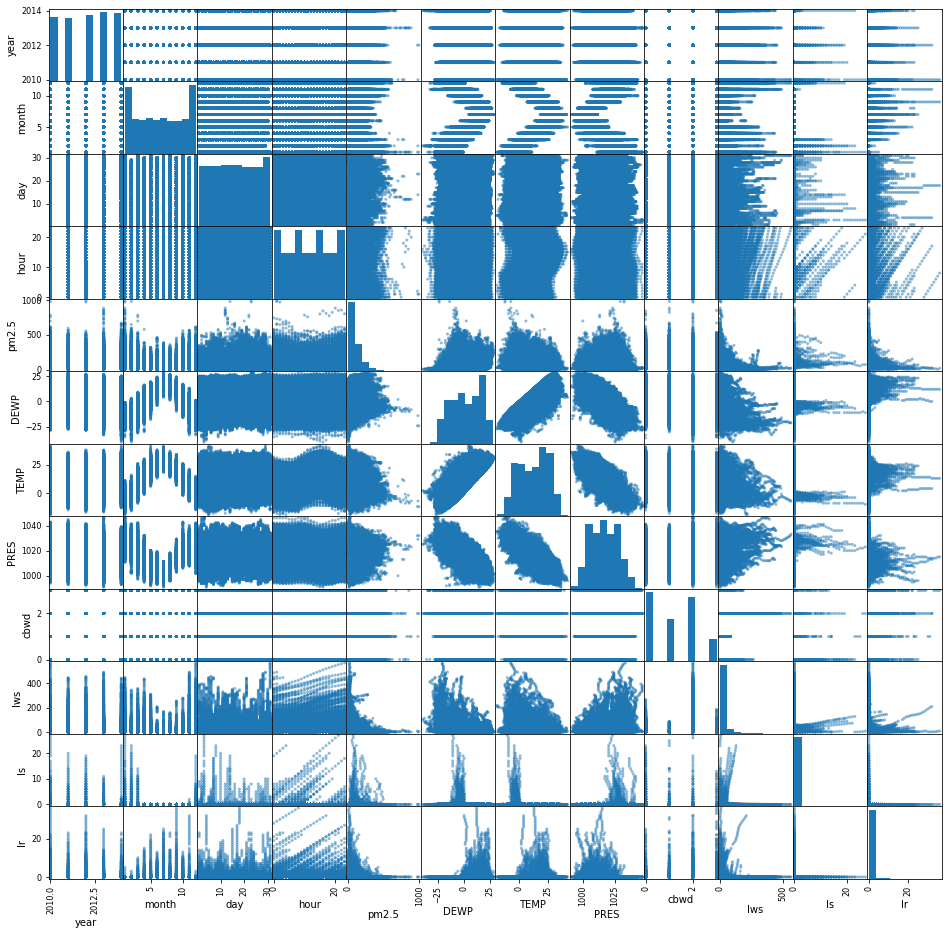

In [639]:
# Multivariate Plots
scatter_matrix(data,figsize=[16,16])
plt.show()

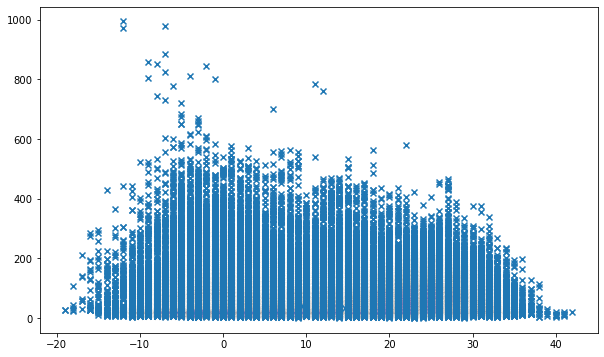

In [640]:
# Zoom in the relation between temp and pm2.5
plt.scatter(data['TEMP'], data['pm2.5'], marker= "x")

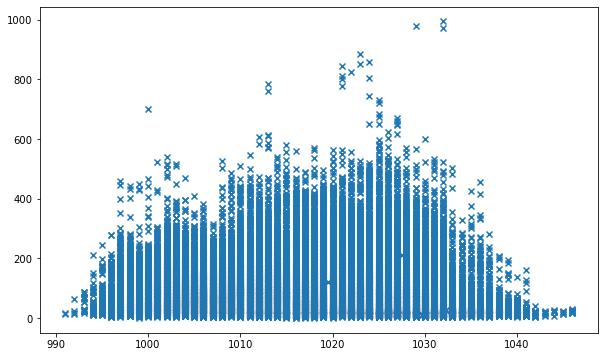

In [641]:
# Zoom in the relation between PRES and pm2.5
plt.scatter(data['PRES'], data['pm2.5'], marker= "x")

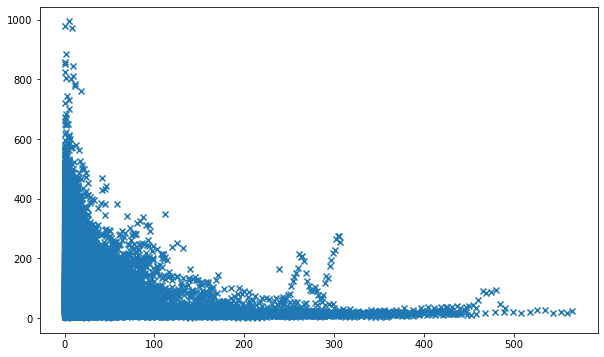

In [642]:
# Zoom in the relation between Iws and pm2.5
plt.scatter(data['Iws'], data['pm2.5'], marker= "x")

### Data Wrangling

In [643]:
# Sign a new column
data = data.assign(anom=pd.Series(np.zeros(len(data), dtype=np.int)).values)
data

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom
timestamp,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,0,1.79,0,0,0
2010-01-02 01:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,0,2.68,0,0,0
2010-01-02 02:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,0,3.57,0,0,0
2010-01-02 03:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,0,5.36,1,0,0
2010-01-02 04:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,0,6.25,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,2014,12,31,19,8.0,-23,-2.0,1034.0,2,231.97,0,0,0
2014-12-31 20:00:00,2014,12,31,20,10.0,-22,-3.0,1034.0,2,237.78,0,0,0
2014-12-31 21:00:00,2014,12,31,21,10.0,-22,-3.0,1034.0,2,242.70,0,0,0


In [644]:
df25 = data.loc[:, 'pm2.5']
df25

timestamp
2010-01-02 00:00:00    129.0
2010-01-02 01:00:00    148.0
2010-01-02 02:00:00    159.0
2010-01-02 03:00:00    181.0
2010-01-02 04:00:00    138.0
                       ...  
2014-12-31 19:00:00      8.0
2014-12-31 20:00:00     10.0
2014-12-31 21:00:00     10.0
2014-12-31 22:00:00      8.0
2014-12-31 23:00:00     12.0
Name: pm2.5, Length: 41757, dtype: float64

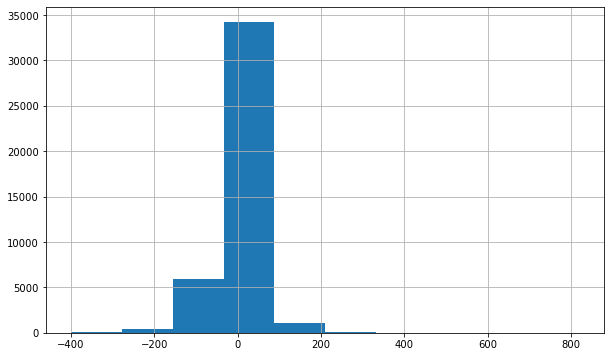

In [645]:
# Different rolling window for labeling
# Rolling window 12hrs
df25_12_column = df25 - df25.rolling(12).mean()
df25_12_column.name = 'diff_12hr_pm2.5'
df25_12_column.hist();

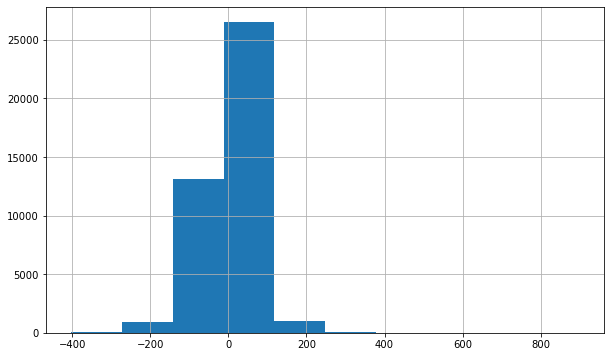

In [646]:
# Rolling window 24hrs
df25_24_column = df25 - df25.rolling(24).mean()
df25_24_column.name = 'diff_24hr_pm2.5'
df25_24_column.hist();

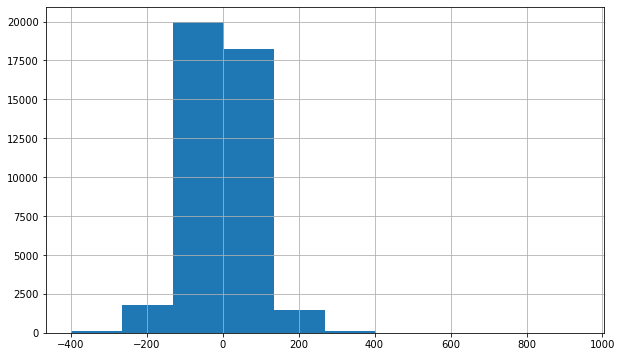

In [647]:
# Rolling window 48hrs
df25_48_column = df25 - df25.rolling(48).mean()
df25_48_column.name = 'diff_48hr_pm2.5'
df25_48_column.hist();

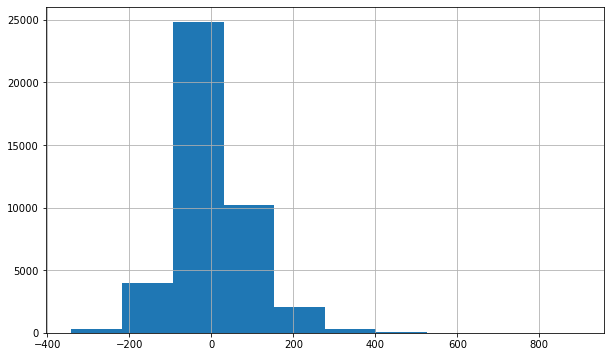

In [648]:
# Rolling window 144hrs
df25_144_column = df25 - df25.rolling(144).mean()
df25_144_column.name = 'diff_144hr_pm2.5'
df25_144_column.hist();

In [649]:
# Declear window list
window_list = [df25_12_column, df25_24_column, df25_48_column, df25_144_column]

In [650]:
df25_24_column

timestamp
2010-01-02 00:00:00         NaN
2010-01-02 01:00:00         NaN
2010-01-02 02:00:00         NaN
2010-01-02 03:00:00         NaN
2010-01-02 04:00:00         NaN
                         ...   
2014-12-31 19:00:00   -3.291667
2014-12-31 20:00:00   -0.625000
2014-12-31 21:00:00   -0.208333
2014-12-31 22:00:00   -2.208333
2014-12-31 23:00:00    1.958333
Name: diff_24hr_pm2.5, Length: 41757, dtype: float64

In [651]:
def get_new_dataframe_with_anomaly_label(original_dataset, window_column_series):
    newdata = pd.concat([data, window_column_series], axis=1)
    newdata.columns.values[-1] = 'diff_pm_2.5'
    newdata.loc[newdata['diff_pm_2.5'] >= 3*(newdata['diff_pm_2.5']).std(),'anom'] = 1
    plt.figure(figsize=(16,8))
    plt.plot(newdata['pm2.5'], markevery=newdata['anom']==1, marker='x', markeredgecolor='red', color='green',markersize=10)
    #print(newdata([newdata['anom']==1]).head(10))
    print('{0} total anomaly numbers : {1}'.format(window_column_series.name,len(newdata[newdata['anom']==1])))
    plt.title('Window size : {0}'.format(window_column_series.name))
    return newdata

In [652]:
newdata = pd.concat([data, df25_24_column], axis=1)
newdata

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom,diff_24hr_pm2.5
timestamp,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,0,1.79,0,0,0,NaN
2010-01-02 01:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,0,2.68,0,0,0,NaN
2010-01-02 02:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,0,3.57,0,0,0,NaN
2010-01-02 03:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,0,5.36,1,0,0,NaN
2010-01-02 04:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,0,6.25,2,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,2014,12,31,19,8.0,-23,-2.0,1034.0,2,231.97,0,0,0,-3.291667
2014-12-31 20:00:00,2014,12,31,20,10.0,-22,-3.0,1034.0,2,237.78,0,0,0,-0.625000
2014-12-31 21:00:00,2014,12,31,21,10.0,-22,-3.0,1034.0,2,242.70,0,0,0,-0.208333


In [653]:
# newdata.columns.values[-1] = 'diff_pm_2.5'
# newdata

In [654]:
# scatter_matrix(newdata,figsize=[16,16])
# plt.plot()

In [655]:
newdata.loc[newdata['diff_24hr_pm2.5'] >= 3*(newdata['diff_24hr_pm2.5']).std(),'anom'] = 1

In [656]:
newdata[newdata['anom'] == 1]

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom,diff_24hr_pm2.5
timestamp,,,,,,,,,,,,,,
2010-01-08 02:00:00,2010,1,8,2,275.0,-20,-16.0,1031.0,3,0.89,0,0,1,190.166667
2010-01-14 01:00:00,2010,1,14,1,257.0,-20,-15.0,1025.0,3,2.67,0,0,1,204.250000
2010-01-16 03:00:00,2010,1,16,3,271.0,-16,-13.0,1035.0,3,0.89,0,0,1,194.541667
2010-01-26 20:00:00,2010,1,26,20,274.0,-11,-5.0,1020.0,3,0.89,0,0,1,200.583333
2010-01-26 21:00:00,2010,1,26,21,340.0,-13,-6.0,1020.0,2,1.79,0,0,1,253.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-09 15:00:00,2014,12,9,15,390.0,-8,0.0,1031.0,1,0.89,0,0,1,283.541667
2014-12-09 16:00:00,2014,12,9,16,375.0,-8,0.0,1031.0,1,1.78,0,0,1,253.625000
2014-12-09 17:00:00,2014,12,9,17,367.0,-8,0.0,1031.0,3,0.89,0,0,1,231.083333


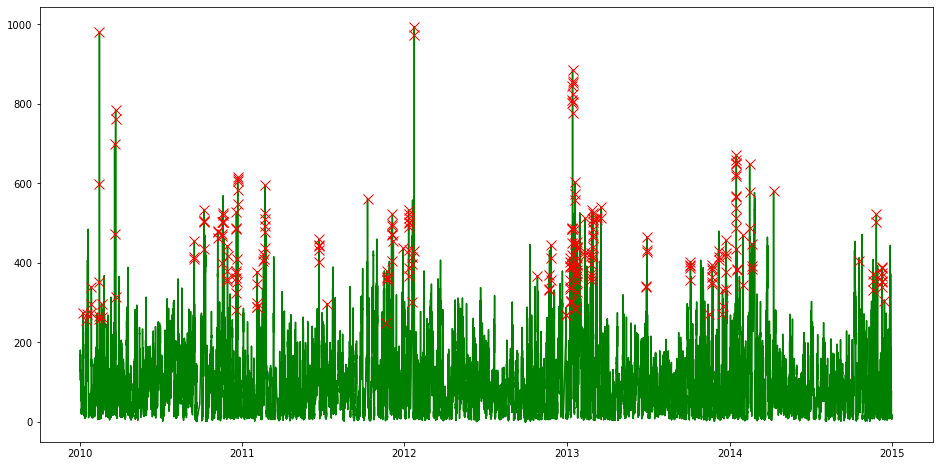

In [657]:
#Flag Anormalies
plt.figure(figsize=(16,8))
plt.plot(newdata['pm2.5'], markevery=newdata['anom']==1, marker='x', markeredgecolor='red', color='green',markersize=10)

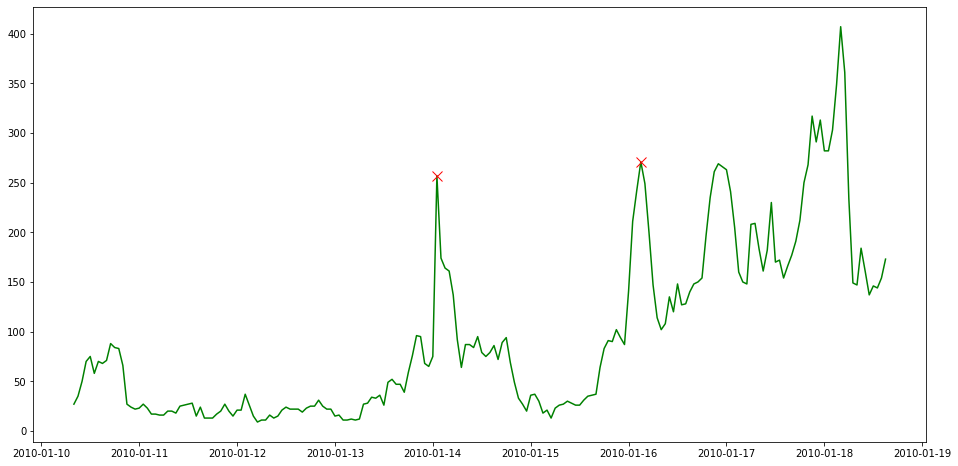

In [658]:
#Flag Anormalies
plt.figure(figsize=(16,8))
plt.plot(newdata['pm2.5'][200:400], markevery=newdata['anom'][200:400]==1, marker='x', markeredgecolor='red', color='green',markersize=10)

diff_12hr_pm2.5 total anomaly numbers : 262
diff_24hr_pm2.5 total anomaly numbers : 251
diff_48hr_pm2.5 total anomaly numbers : 263
diff_144hr_pm2.5 total anomaly numbers : 384


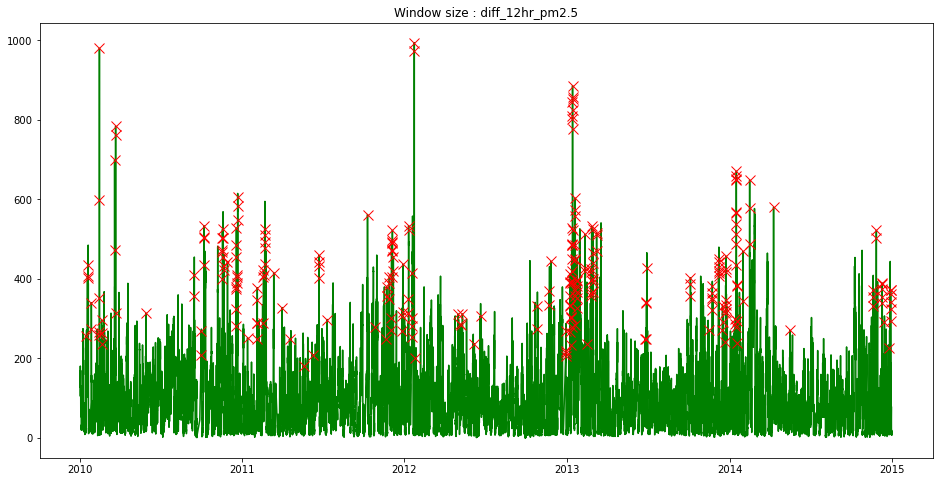

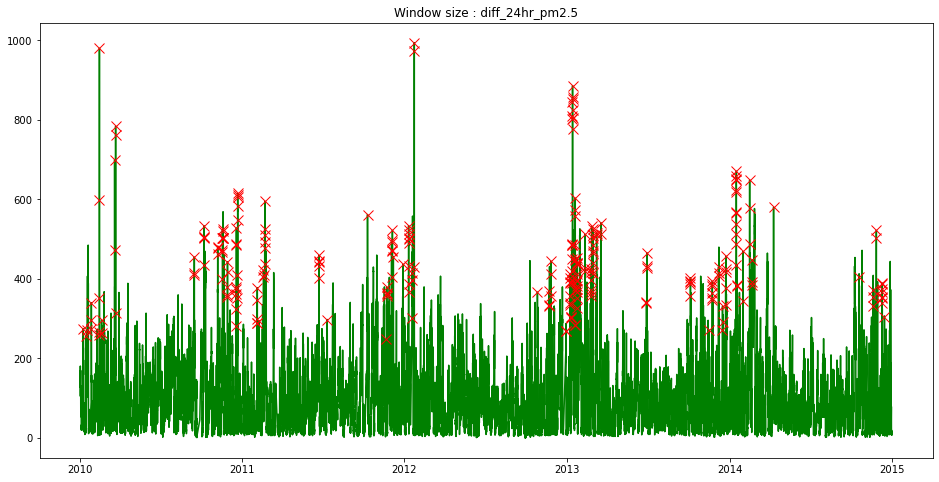

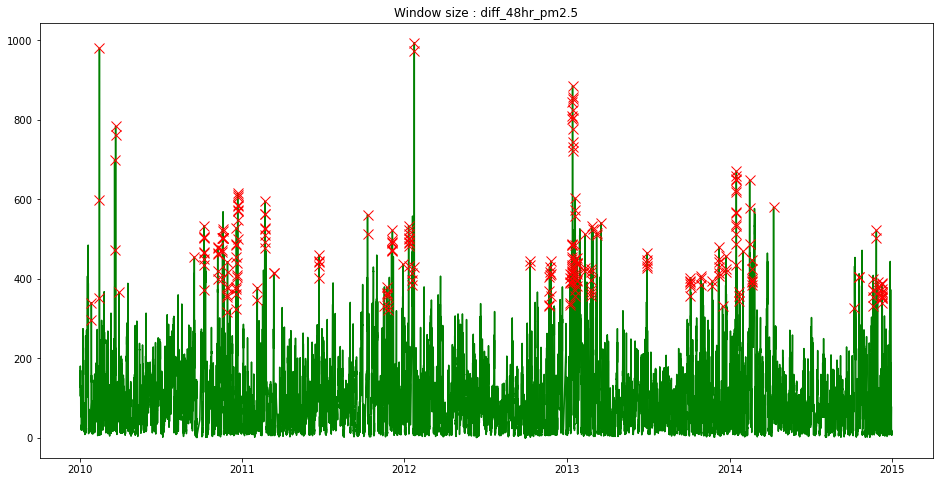

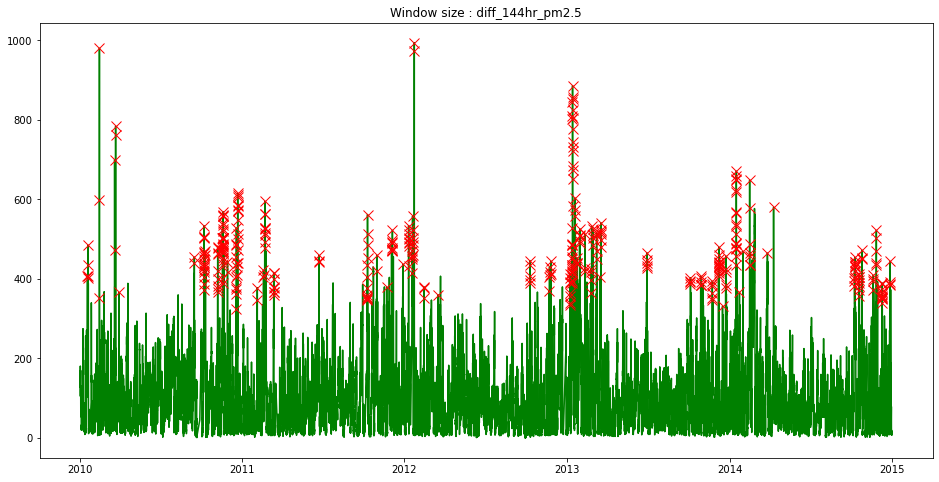

In [659]:
newdata_list = []
for i in window_list:
    #print(i)
    newdata_list.append(get_new_dataframe_with_anomaly_label(data, i))

In [660]:
# All 4 dataframe
newdata_list

[                     year  month  day  hour  pm2.5  DEWP  TEMP    PRES  cbwd  \
 timestamp                                                                      
 2010-01-02 00:00:00  2010      1    2     0  129.0   -16  -4.0  1020.0     0   
 2010-01-02 01:00:00  2010      1    2     1  148.0   -15  -4.0  1020.0     0   
 2010-01-02 02:00:00  2010      1    2     2  159.0   -11  -5.0  1021.0     0   
 2010-01-02 03:00:00  2010      1    2     3  181.0    -7  -5.0  1022.0     0   
 2010-01-02 04:00:00  2010      1    2     4  138.0    -7  -5.0  1022.0     0   
 ...                   ...    ...  ...   ...    ...   ...   ...     ...   ...   
 2014-12-31 19:00:00  2014     12   31    19    8.0   -23  -2.0  1034.0     2   
 2014-12-31 20:00:00  2014     12   31    20   10.0   -22  -3.0  1034.0     2   
 2014-12-31 21:00:00  2014     12   31    21   10.0   -22  -3.0  1034.0     2   
 2014-12-31 22:00:00  2014     12   31    22    8.0   -22  -4.0  1034.0     2   
 2014-12-31 23:00:00  2014  

In [661]:
# we use the first dataset in newdata_list in our project
newdata = newdata_list[3]
# drop the first few lines with NaN in diff_pm_2.5
newdata = newdata.dropna()
tag = newdata['anom'].copy()

In [662]:
# this part is refer to "https://www.kaggle.com/robinteuwens/anomaly-detection-with-auto-encoders"
# manual parameter 
RATIO_TO_ANOMALY = 10

# splitting by class
anomaly = newdata[newdata.anom == 1]
normal = newdata[newdata.anom == 0]

# undersample clean transactions
normal_undersampled = normal.sample(
    int(len(anomaly) * RATIO_TO_ANOMALY),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([anomaly, normal_undersampled])
column_names = list(visualisation_initial.drop('anom', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('anom', axis=1).values, \
                   visualisation_initial.anom.values


def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d')
    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')
    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Anomaly'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Normal'
    )
                         
    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as)
    plt.show

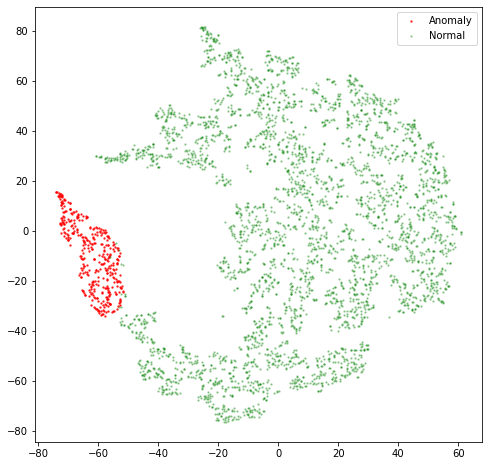

In [663]:
# print the t-sne
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

In [664]:
# we use the first 31318 data for training
training_data = newdata.iloc[:31318, :]
training_data_tag = tag[:31318]

# split training data into normal and validation
pure_training_data = training_data.iloc[:23489, :]
pure_training_tag = training_data_tag[:23489]
validation_training_data = training_data.iloc[23489:, :]
validation_training_tag = training_data_tag[23489:]

# generate normal/anomaly data mask
normal_mask = pure_training_data['anom']==0
anomaly_mask = pure_training_data['anom']==1

normal_pure_training_tag = pure_training_tag[normal_mask]
anomaly_pure_training_tag = pure_training_tag[anomaly_mask]

# normalize the pure training data
pure_training_data=(pure_training_data-pure_training_data.mean())/pure_training_data.std()

# normalize the validation data
validation_training_data=(validation_training_data-validation_training_data.mean())/validation_training_data.std()

# the left data is for testing
testing_data = newdata.iloc[31318:, :]
testing_data_tag = tag[31318:]

# normalize the testing data
testing_data = (testing_data-testing_data.mean())/testing_data.std()


# make a copy for seperate purpose
whole_data = newdata.copy()
whole_data.drop('anom',axis=1,inplace=True)
whole_data_wot = whole_data.values

In [665]:
# the autoencoder does not need to know the tag information and some other information for tag purpose, so drop it
pure_training_data.drop('anom',axis=1,inplace=True)
pure_training_data.drop('diff_pm_2.5',axis=1,inplace=True)
# pure_training_data.drop('year',axis=1,inplace=True)
# pure_training_data.drop('month',axis=1,inplace=True)
# pure_training_data.drop('day',axis=1,inplace=True)
# pure_training_data.drop('hour',axis=1,inplace=True)

validation_training_data.drop('anom',axis=1,inplace=True)
validation_training_data.drop('diff_pm_2.5',axis=1,inplace=True)
# validation_training_data.drop('year',axis=1,inplace=True)
# validation_training_data.drop('month',axis=1,inplace=True)
# validation_training_data.drop('day',axis=1,inplace=True)
# validation_training_data.drop('hour',axis=1,inplace=True)

testing_data.drop('anom',axis=1,inplace=True)
testing_data.drop('diff_pm_2.5',axis=1,inplace=True)
# testing_data.drop('year',axis=1,inplace=True)
# testing_data.drop('month',axis=1,inplace=True)
# testing_data.drop('day',axis=1,inplace=True)
# testing_data.drop('hour',axis=1,inplace=True)


In [666]:
df_normal = pure_training_data[normal_mask]
df_anomaly = pure_training_data[anomaly_mask]

In [667]:
x_normal_train = df_normal.values
X_anomaly = df_anomaly.values
x_normal_validation = validation_training_data
X_testing = testing_data.values

In [668]:
X_testing.shape

(10296, 12)

In [669]:
model_list = []
history_list = []
for outlayer_dim in range(3, 12):
    for inlayer_dim in range(2, outlayer_dim):
        model = Sequential()
        model.add(Dense(outlayer_dim, input_dim=x_normal_train.shape[1], activation='relu'))
        model.add(Dense(inlayer_dim, activation='relu')) # latent code layer
        model.add(Dense(outlayer_dim, activation='relu'))
        model.add(Dense(x_normal_train.shape[1])) # Multiple output neurons
        model.compile(loss='mean_squared_error', optimizer='adam')
        history = model.fit(x_normal_train, x_normal_train, 
                  epochs=100, 
                  batch_size=512,
                  validation_data=(x_normal_validation, x_normal_validation),
                  shuffle=True)
        model_list.append(model)
        history_list.append(history)

Train on 23301 samples, validate on 7829 samples
Epoch 1/100
23301/23301 [==============================] - 17s 716us/sample - loss: 1.0004 - val_loss: 0.9907
Epoch 2/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.9642 - val_loss: 0.9631
Epoch 3/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.9390 - val_loss: 0.9404
Epoch 4/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.9155 - val_loss: 0.9180
Epoch 5/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.8921 - val_loss: 0.8954
Epoch 6/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.8692 - val_loss: 0.8740
Epoch 7/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.8469 - val_loss: 0.8528
Epoch 8/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.8247 - val_loss: 0.8319
Epoch 9/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.8

Epoch 76/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6393 - val_loss: 0.6628
Epoch 77/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6392 - val_loss: 0.6631
Epoch 78/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6392 - val_loss: 0.6626
Epoch 79/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6391 - val_loss: 0.6626
Epoch 80/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6390 - val_loss: 0.6630
Epoch 81/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6390 - val_loss: 0.6625
Epoch 82/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6389 - val_loss: 0.6625
Epoch 83/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.6388 - val_loss: 0.6624
Epoch 84/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.6388 - val_loss: 0.6624
Epoch 85/100
23301/

Epoch 51/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.7392 - val_loss: 0.7659
Epoch 52/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.7391 - val_loss: 0.7657
Epoch 53/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.7390 - val_loss: 0.7657
Epoch 54/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.7389 - val_loss: 0.7656
Epoch 55/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.7388 - val_loss: 0.7654
Epoch 56/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.7387 - val_loss: 0.7655
Epoch 57/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.7386 - val_loss: 0.7656
Epoch 58/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.7386 - val_loss: 0.7654
Epoch 59/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.7385 - val_loss: 0.7652
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5769 - val_loss: 0.6009
Epoch 27/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5740 - val_loss: 0.5986
Epoch 28/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5710 - val_loss: 0.5956
Epoch 29/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5683 - val_loss: 0.5930
Epoch 30/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5647 - val_loss: 0.5894
Epoch 31/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5602 - val_loss: 0.5841
Epoch 32/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5534 - val_loss: 0.5762
Epoch 33/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.5441 - val_loss: 0.5649
Epoch 34/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.5327 - val_loss: 0.5523
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 14s 608us/sample - loss: 0.9860 - val_loss: 0.9707
Epoch 2/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.9541 - val_loss: 0.9242
Epoch 3/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.9094 - val_loss: 0.8616
Epoch 4/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.8483 - val_loss: 0.8009
Epoch 5/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.7825 - val_loss: 0.7512
Epoch 6/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.7313 - val_loss: 0.7176
Epoch 7/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.7013 - val_loss: 0.6959
Epoch 8/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.6836 - val_loss: 0.6808
Epoch 9/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.6716 - val_loss: 0.6700
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 0s 21us/sample - loss: 0.5136 - val_loss: 0.5267
Epoch 77/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5134 - val_loss: 0.5263
Epoch 78/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5131 - val_loss: 0.5263
Epoch 79/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5128 - val_loss: 0.5263
Epoch 80/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5126 - val_loss: 0.5254
Epoch 81/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5123 - val_loss: 0.5253
Epoch 82/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5121 - val_loss: 0.5253
Epoch 83/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5119 - val_loss: 0.5251
Epoch 84/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5117 - val_loss: 0.5249
Epoch 85/100
23301/23301 [======

Epoch 51/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.5059 - val_loss: 0.5142
Epoch 52/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5051 - val_loss: 0.5133
Epoch 53/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5046 - val_loss: 0.5130
Epoch 54/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5040 - val_loss: 0.5118
Epoch 55/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5036 - val_loss: 0.5115
Epoch 56/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5032 - val_loss: 0.5110
Epoch 57/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5025 - val_loss: 0.5101
Epoch 58/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.5020 - val_loss: 0.5096
Epoch 59/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.5019 - val_loss: 0.5094
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.4782 - val_loss: 0.5049
Epoch 27/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.4763 - val_loss: 0.5025
Epoch 28/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.4746 - val_loss: 0.4996
Epoch 29/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.4732 - val_loss: 0.4979
Epoch 30/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.4718 - val_loss: 0.4967
Epoch 31/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4707 - val_loss: 0.4935
Epoch 32/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4691 - val_loss: 0.4912
Epoch 33/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4680 - val_loss: 0.4898
Epoch 34/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4673 - val_loss: 0.4884
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 18s 776us/sample - loss: 0.9815 - val_loss: 0.9864
Epoch 2/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.9539 - val_loss: 0.9632
Epoch 3/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.9247 - val_loss: 0.9342
Epoch 4/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.8901 - val_loss: 0.8990
Epoch 5/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.8498 - val_loss: 0.8601
Epoch 6/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.8100 - val_loss: 0.8232
Epoch 7/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.7742 - val_loss: 0.7906
Epoch 8/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.7462 - val_loss: 0.7645
Epoch 9/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.7233 - val_loss: 0.7431
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 1s 23us/sample - loss: 0.4854 - val_loss: 0.5043
Epoch 77/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.4843 - val_loss: 0.5025
Epoch 78/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.4832 - val_loss: 0.5027
Epoch 79/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.4822 - val_loss: 0.5009
Epoch 80/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.4812 - val_loss: 0.4989
Epoch 81/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4804 - val_loss: 0.4995
Epoch 82/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4796 - val_loss: 0.4977
Epoch 83/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4789 - val_loss: 0.4969
Epoch 84/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4783 - val_loss: 0.4969
Epoch 85/100
23301/23301 [======

Epoch 51/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4769 - val_loss: 0.4863
Epoch 52/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4766 - val_loss: 0.4855
Epoch 53/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4763 - val_loss: 0.4856
Epoch 54/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4761 - val_loss: 0.4854
Epoch 55/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4759 - val_loss: 0.4858
Epoch 56/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4757 - val_loss: 0.4861
Epoch 57/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4756 - val_loss: 0.4869
Epoch 58/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4753 - val_loss: 0.4862
Epoch 59/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4751 - val_loss: 0.4871
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4942 - val_loss: 0.5440
Epoch 27/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4918 - val_loss: 0.5416
Epoch 28/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4896 - val_loss: 0.5384
Epoch 29/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4873 - val_loss: 0.5349
Epoch 30/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4853 - val_loss: 0.5325
Epoch 31/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4832 - val_loss: 0.5303
Epoch 32/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4811 - val_loss: 0.5273
Epoch 33/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4790 - val_loss: 0.5248
Epoch 34/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4768 - val_loss: 0.5221
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 15s 636us/sample - loss: 1.0640 - val_loss: 1.0004
Epoch 2/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.9712 - val_loss: 0.9451
Epoch 3/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.9209 - val_loss: 0.8994
Epoch 4/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.8693 - val_loss: 0.8503
Epoch 5/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.8054 - val_loss: 0.7935
Epoch 6/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.7396 - val_loss: 0.7417
Epoch 7/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.6906 - val_loss: 0.7046
Epoch 8/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.6575 - val_loss: 0.6765
Epoch 9/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.6325 - val_loss: 0.6535
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 0s 18us/sample - loss: 0.3663 - val_loss: 0.3495
Epoch 77/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.3663 - val_loss: 0.3499
Epoch 78/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.3663 - val_loss: 0.3502
Epoch 79/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.3661 - val_loss: 0.3499
Epoch 80/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.3661 - val_loss: 0.3508
Epoch 81/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.3660 - val_loss: 0.3502
Epoch 82/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.3658 - val_loss: 0.3504
Epoch 83/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.3658 - val_loss: 0.3507
Epoch 84/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.3659 - val_loss: 0.3512
Epoch 85/100
23301/23301 [======

Epoch 51/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.5365 - val_loss: 0.5560
Epoch 52/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.5344 - val_loss: 0.5544
Epoch 53/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.5325 - val_loss: 0.5530
Epoch 54/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.5309 - val_loss: 0.5507
Epoch 55/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.5294 - val_loss: 0.5503
Epoch 56/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.5281 - val_loss: 0.5488
Epoch 57/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.5269 - val_loss: 0.5482
Epoch 58/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.5257 - val_loss: 0.5473
Epoch 59/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.5247 - val_loss: 0.5463
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.5181 - val_loss: 0.5073
Epoch 27/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.5100 - val_loss: 0.4991
Epoch 28/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.5036 - val_loss: 0.4936
Epoch 29/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4985 - val_loss: 0.4901
Epoch 30/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4942 - val_loss: 0.4850
Epoch 31/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4906 - val_loss: 0.4818
Epoch 32/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4877 - val_loss: 0.4799
Epoch 33/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4848 - val_loss: 0.4776
Epoch 34/100
23301/23301 [==============================] - 0s 18us/sample - loss: 0.4828 - val_loss: 0.4760
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 15s 638us/sample - loss: 1.0238 - val_loss: 1.0158
Epoch 2/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.9800 - val_loss: 0.9887
Epoch 3/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.9309 - val_loss: 0.9306
Epoch 4/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.8365 - val_loss: 0.8350
Epoch 5/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.7418 - val_loss: 0.7628
Epoch 6/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6839 - val_loss: 0.7169
Epoch 7/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6484 - val_loss: 0.6867
Epoch 8/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6223 - val_loss: 0.6623
Epoch 9/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6010 - val_loss: 0.6409
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 0s 19us/sample - loss: 0.3195 - val_loss: 0.3086
Epoch 77/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3193 - val_loss: 0.3089
Epoch 78/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3193 - val_loss: 0.3083
Epoch 79/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3192 - val_loss: 0.3086
Epoch 80/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3191 - val_loss: 0.3086
Epoch 81/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3190 - val_loss: 0.3084
Epoch 82/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3189 - val_loss: 0.3082
Epoch 83/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3189 - val_loss: 0.3084
Epoch 84/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3188 - val_loss: 0.3086
Epoch 85/100
23301/23301 [======

Epoch 51/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3056 - val_loss: 0.3036
Epoch 52/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3050 - val_loss: 0.3031
Epoch 53/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3045 - val_loss: 0.3008
Epoch 54/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3038 - val_loss: 0.3006
Epoch 55/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3035 - val_loss: 0.2997
Epoch 56/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3029 - val_loss: 0.2982
Epoch 57/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3024 - val_loss: 0.2978
Epoch 58/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3020 - val_loss: 0.2970
Epoch 59/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3017 - val_loss: 0.2967
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3702 - val_loss: 0.4057
Epoch 27/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.3653 - val_loss: 0.4015
Epoch 28/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3610 - val_loss: 0.3970
Epoch 29/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3565 - val_loss: 0.3935
Epoch 30/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3528 - val_loss: 0.3893
Epoch 31/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3490 - val_loss: 0.3854
Epoch 32/100
23301/23301 [==============================] - 1s 21us/sample - loss: 0.3454 - val_loss: 0.3806
Epoch 33/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3421 - val_loss: 0.3764
Epoch 34/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3390 - val_loss: 0.3722
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 16s 707us/sample - loss: 0.9858 - val_loss: 0.9818
Epoch 2/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.9349 - val_loss: 0.9123
Epoch 3/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.8533 - val_loss: 0.8354
Epoch 4/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.7833 - val_loss: 0.7852
Epoch 5/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.7349 - val_loss: 0.7477
Epoch 6/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.7044 - val_loss: 0.7229
Epoch 7/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6845 - val_loss: 0.7058
Epoch 8/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6680 - val_loss: 0.6892
Epoch 9/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.6517 - val_loss: 0.6722
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 0s 21us/sample - loss: 0.4647 - val_loss: 0.4802
Epoch 77/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4641 - val_loss: 0.4797
Epoch 78/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4634 - val_loss: 0.4797
Epoch 79/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.4628 - val_loss: 0.4785
Epoch 80/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.4622 - val_loss: 0.4777
Epoch 81/100
23301/23301 [==============================] - 1s 27us/sample - loss: 0.4614 - val_loss: 0.4779
Epoch 82/100
23301/23301 [==============================] - 1s 30us/sample - loss: 0.4609 - val_loss: 0.4775
Epoch 83/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.4600 - val_loss: 0.4758
Epoch 84/100
23301/23301 [==============================] - 0s 19us/sample - loss: 0.4595 - val_loss: 0.4754
Epoch 85/100
23301/23301 [======

Epoch 51/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3414 - val_loss: 0.3722
Epoch 52/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3412 - val_loss: 0.3718
Epoch 53/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3410 - val_loss: 0.3708
Epoch 54/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3409 - val_loss: 0.3721
Epoch 55/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3408 - val_loss: 0.3701
Epoch 56/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3406 - val_loss: 0.3721
Epoch 57/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3405 - val_loss: 0.3725
Epoch 58/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3402 - val_loss: 0.3717
Epoch 59/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3402 - val_loss: 0.3707
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.3136 - val_loss: 0.3071
Epoch 27/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.3093 - val_loss: 0.3014
Epoch 28/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3056 - val_loss: 0.2984
Epoch 29/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.3023 - val_loss: 0.2964
Epoch 30/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2998 - val_loss: 0.2938
Epoch 31/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.2975 - val_loss: 0.2918
Epoch 32/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2954 - val_loss: 0.2898
Epoch 33/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.2937 - val_loss: 0.2890
Epoch 34/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.2920 - val_loss: 0.2886
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 17s 735us/sample - loss: 1.0226 - val_loss: 0.9727
Epoch 2/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.9492 - val_loss: 0.9399
Epoch 3/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.9163 - val_loss: 0.9044
Epoch 4/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.8758 - val_loss: 0.8588
Epoch 5/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.8251 - val_loss: 0.8057
Epoch 6/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.7696 - val_loss: 0.7526
Epoch 7/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.7156 - val_loss: 0.7069
Epoch 8/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.6686 - val_loss: 0.6698
Epoch 9/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.6313 - val_loss: 0.6419
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 1s 22us/sample - loss: 0.2212 - val_loss: 0.2268
Epoch 77/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2208 - val_loss: 0.2269
Epoch 78/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2203 - val_loss: 0.2251
Epoch 79/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2200 - val_loss: 0.2246
Epoch 80/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2196 - val_loss: 0.2245
Epoch 81/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2193 - val_loss: 0.2235
Epoch 82/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2190 - val_loss: 0.2231
Epoch 83/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2186 - val_loss: 0.2216
Epoch 84/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2184 - val_loss: 0.2211
Epoch 85/100
23301/23301 [======

Epoch 51/100
23301/23301 [==============================] - 0s 20us/sample - loss: 0.1468 - val_loss: 0.1673
Epoch 52/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.1463 - val_loss: 0.1669
Epoch 53/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.1460 - val_loss: 0.1670
Epoch 54/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.1457 - val_loss: 0.1657
Epoch 55/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.1454 - val_loss: 0.1662
Epoch 56/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.1453 - val_loss: 0.1653
Epoch 57/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.1449 - val_loss: 0.1645
Epoch 58/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.1447 - val_loss: 0.1643
Epoch 59/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.1445 - val_loss: 0.1645
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 0s 21us/sample - loss: 0.2428 - val_loss: 0.2334
Epoch 27/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2386 - val_loss: 0.2277
Epoch 28/100
23301/23301 [==============================] - 1s 21us/sample - loss: 0.2347 - val_loss: 0.2222
Epoch 29/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2308 - val_loss: 0.2168
Epoch 30/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2266 - val_loss: 0.2124
Epoch 31/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2228 - val_loss: 0.2071
Epoch 32/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2195 - val_loss: 0.2036
Epoch 33/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.2153 - val_loss: 0.1999
Epoch 34/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2093 - val_loss: 0.1961
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 18s 789us/sample - loss: 0.9962 - val_loss: 0.9917
Epoch 2/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.9662 - val_loss: 0.9654
Epoch 3/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.9273 - val_loss: 0.9169
Epoch 4/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.8609 - val_loss: 0.8459
Epoch 5/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.7834 - val_loss: 0.7857
Epoch 6/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.7262 - val_loss: 0.7420
Epoch 7/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.6862 - val_loss: 0.7085
Epoch 8/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.6611 - val_loss: 0.6857
Epoch 9/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.6463 - val_loss: 0.6720
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 1s 22us/sample - loss: 0.4499 - val_loss: 0.4861
Epoch 77/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4480 - val_loss: 0.4839
Epoch 78/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4461 - val_loss: 0.4824
Epoch 79/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4446 - val_loss: 0.4801
Epoch 80/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4431 - val_loss: 0.4785
Epoch 81/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4415 - val_loss: 0.4773
Epoch 82/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4403 - val_loss: 0.4752
Epoch 83/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4391 - val_loss: 0.4741
Epoch 84/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.4379 - val_loss: 0.4715
Epoch 85/100
23301/23301 [======

Epoch 51/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3907 - val_loss: 0.4120
Epoch 52/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3904 - val_loss: 0.4111
Epoch 53/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3901 - val_loss: 0.4103
Epoch 54/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3901 - val_loss: 0.4103
Epoch 55/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3898 - val_loss: 0.4104
Epoch 56/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3896 - val_loss: 0.4097
Epoch 57/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3895 - val_loss: 0.4095
Epoch 58/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3895 - val_loss: 0.4094
Epoch 59/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3892 - val_loss: 0.4090
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3366 - val_loss: 0.3731
Epoch 27/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3276 - val_loss: 0.3639
Epoch 28/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3214 - val_loss: 0.3568
Epoch 29/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3163 - val_loss: 0.3512
Epoch 30/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3121 - val_loss: 0.3471
Epoch 31/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3086 - val_loss: 0.3432
Epoch 32/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.3055 - val_loss: 0.3392
Epoch 33/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.3026 - val_loss: 0.3363
Epoch 34/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2999 - val_loss: 0.3339
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 18s 751us/sample - loss: 1.0156 - val_loss: 0.9808
Epoch 2/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.9378 - val_loss: 0.9332
Epoch 3/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.8874 - val_loss: 0.8881
Epoch 4/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.8298 - val_loss: 0.8308
Epoch 5/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.7618 - val_loss: 0.7705
Epoch 6/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.6906 - val_loss: 0.7100
Epoch 7/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.6341 - val_loss: 0.6626
Epoch 8/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.5935 - val_loss: 0.6214
Epoch 9/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.5608 - val_loss: 0.5895
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 1s 23us/sample - loss: 0.2213 - val_loss: 0.2121
Epoch 77/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.2212 - val_loss: 0.2129
Epoch 78/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2212 - val_loss: 0.2121
Epoch 79/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2211 - val_loss: 0.2118
Epoch 80/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2209 - val_loss: 0.2106
Epoch 81/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2209 - val_loss: 0.2100
Epoch 82/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2208 - val_loss: 0.2096
Epoch 83/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2207 - val_loss: 0.2091
Epoch 84/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2206 - val_loss: 0.2095
Epoch 85/100
23301/23301 [======

Epoch 51/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2236 - val_loss: 0.2414
Epoch 52/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2235 - val_loss: 0.2408
Epoch 53/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2234 - val_loss: 0.2408
Epoch 54/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2232 - val_loss: 0.2407
Epoch 55/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2230 - val_loss: 0.2410
Epoch 56/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2230 - val_loss: 0.2404
Epoch 57/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2231 - val_loss: 0.2395
Epoch 58/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2227 - val_loss: 0.2388
Epoch 59/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2225 - val_loss: 0.2386
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2776 - val_loss: 0.2770
Epoch 27/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2690 - val_loss: 0.2689
Epoch 28/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2603 - val_loss: 0.2609
Epoch 29/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2517 - val_loss: 0.2511
Epoch 30/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2422 - val_loss: 0.2396
Epoch 31/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2286 - val_loss: 0.2211
Epoch 32/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2100 - val_loss: 0.1995
Epoch 33/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1916 - val_loss: 0.1812
Epoch 34/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1789 - val_loss: 0.1716
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 18s 764us/sample - loss: 1.0908 - val_loss: 0.9893
Epoch 2/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.9415 - val_loss: 0.9112
Epoch 3/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.8589 - val_loss: 0.8345
Epoch 4/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.7747 - val_loss: 0.7628
Epoch 5/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.6951 - val_loss: 0.6983
Epoch 6/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.6262 - val_loss: 0.6415
Epoch 7/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.5739 - val_loss: 0.5986
Epoch 8/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.5384 - val_loss: 0.5653
Epoch 9/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.5119 - val_loss: 0.5378
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 1s 23us/sample - loss: 0.0830 - val_loss: 0.0940
Epoch 77/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0830 - val_loss: 0.0937
Epoch 78/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0828 - val_loss: 0.0938
Epoch 79/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0827 - val_loss: 0.0935
Epoch 80/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0827 - val_loss: 0.0933
Epoch 81/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0826 - val_loss: 0.0935
Epoch 82/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0825 - val_loss: 0.0933
Epoch 83/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0824 - val_loss: 0.0932
Epoch 84/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0823 - val_loss: 0.0931
Epoch 85/100
23301/23301 [======

Epoch 51/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.5012 - val_loss: 0.5251
Epoch 52/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4981 - val_loss: 0.5194
Epoch 53/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4939 - val_loss: 0.5183
Epoch 54/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4900 - val_loss: 0.5151
Epoch 55/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4859 - val_loss: 0.5118
Epoch 56/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4819 - val_loss: 0.5086
Epoch 57/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4786 - val_loss: 0.5045
Epoch 58/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4749 - val_loss: 0.5026
Epoch 59/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4714 - val_loss: 0.5007
Epoch 60/100
23301/

Epoch 26/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.5279 - val_loss: 0.4974
Epoch 27/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4945 - val_loss: 0.4647
Epoch 28/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4747 - val_loss: 0.4497
Epoch 29/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4612 - val_loss: 0.4412
Epoch 30/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4520 - val_loss: 0.4325
Epoch 31/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4454 - val_loss: 0.4283
Epoch 32/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4398 - val_loss: 0.4240
Epoch 33/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4355 - val_loss: 0.4219
Epoch 34/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4316 - val_loss: 0.4183
Epoch 35/100
23301/

Epoch 1/100
23301/23301 [==============================] - 18s 769us/sample - loss: 1.0747 - val_loss: 0.9936
Epoch 2/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.9243 - val_loss: 0.8966
Epoch 3/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.8275 - val_loss: 0.8217
Epoch 4/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.7601 - val_loss: 0.7678
Epoch 5/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.7128 - val_loss: 0.7247
Epoch 6/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.6756 - val_loss: 0.6891
Epoch 7/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.6459 - val_loss: 0.6572
Epoch 8/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.6189 - val_loss: 0.6272
Epoch 9/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.5937 - val_loss: 0.5997
Epoch 10/100
23301/23301 [

23301/23301 [==============================] - 1s 23us/sample - loss: 0.2281 - val_loss: 0.2302
Epoch 77/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2276 - val_loss: 0.2297
Epoch 78/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2270 - val_loss: 0.2295
Epoch 79/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2265 - val_loss: 0.2280
Epoch 80/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2261 - val_loss: 0.2273
Epoch 81/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.2254 - val_loss: 0.2269
Epoch 82/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2249 - val_loss: 0.2269
Epoch 83/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2244 - val_loss: 0.2265
Epoch 84/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.2240 - val_loss: 0.2270
Epoch 85/100
23301/23301 [======

23301/23301 [==============================] - 1s 24us/sample - loss: 0.1733 - val_loss: 0.2195
Epoch 51/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1718 - val_loss: 0.2172
Epoch 52/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1703 - val_loss: 0.2157
Epoch 53/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1686 - val_loss: 0.2136
Epoch 54/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1671 - val_loss: 0.2121
Epoch 55/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1654 - val_loss: 0.2091
Epoch 56/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1638 - val_loss: 0.2066
Epoch 57/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1621 - val_loss: 0.2044
Epoch 58/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1604 - val_loss: 0.2026
Epoch 59/100
23301/23301 [======

Epoch 25/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1717 - val_loss: 0.1621
Epoch 26/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1695 - val_loss: 0.1599
Epoch 27/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1677 - val_loss: 0.1586
Epoch 28/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1660 - val_loss: 0.1577
Epoch 29/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.1647 - val_loss: 0.1571
Epoch 30/100
23301/23301 [==============================] - 1s 26us/sample - loss: 0.1637 - val_loss: 0.1558
Epoch 31/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1627 - val_loss: 0.1553
Epoch 32/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.1620 - val_loss: 0.1547
Epoch 33/100
23301/23301 [==============================] - 1s 26us/sample - loss: 0.1612 - val_loss: 0.1552
Epoch 34/100
23301/

23301/23301 [==============================] - 1s 23us/sample - loss: 0.1434 - val_loss: 0.1759
Train on 23301 samples, validate on 7829 samples
Epoch 1/100
23301/23301 [==============================] - 18s 781us/sample - loss: 1.0875 - val_loss: 1.0039
Epoch 2/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.9461 - val_loss: 0.9054
Epoch 3/100
23301/23301 [==============================] - 1s 22us/sample - loss: 0.8305 - val_loss: 0.8084
Epoch 4/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.7432 - val_loss: 0.7440
Epoch 5/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.6755 - val_loss: 0.6800
Epoch 6/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.6084 - val_loss: 0.6162
Epoch 7/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.5453 - val_loss: 0.5549
Epoch 8/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4897 - val_lo

Epoch 75/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0616 - val_loss: 0.0745
Epoch 76/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0600 - val_loss: 0.0717
Epoch 77/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0586 - val_loss: 0.0711
Epoch 78/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0572 - val_loss: 0.0692
Epoch 79/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0562 - val_loss: 0.0687
Epoch 80/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0550 - val_loss: 0.0677
Epoch 81/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0540 - val_loss: 0.0655
Epoch 82/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0534 - val_loss: 0.0651
Epoch 83/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.0524 - val_loss: 0.0639
Epoch 84/100
23301/

Epoch 50/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1531 - val_loss: 0.1541
Epoch 51/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1522 - val_loss: 0.1529
Epoch 52/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1510 - val_loss: 0.1525
Epoch 53/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1499 - val_loss: 0.1514
Epoch 54/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1486 - val_loss: 0.1503
Epoch 55/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1475 - val_loss: 0.1499
Epoch 56/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1462 - val_loss: 0.1490
Epoch 57/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1446 - val_loss: 0.1467
Epoch 58/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1428 - val_loss: 0.1461
Epoch 59/100
23301/

Epoch 25/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1573 - val_loss: 0.1562
Epoch 26/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1547 - val_loss: 0.1552
Epoch 27/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1523 - val_loss: 0.1537
Epoch 28/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1504 - val_loss: 0.1524
Epoch 29/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1490 - val_loss: 0.1520
Epoch 30/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1477 - val_loss: 0.1513
Epoch 31/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1466 - val_loss: 0.1513
Epoch 32/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1455 - val_loss: 0.1504
Epoch 33/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.1447 - val_loss: 0.1508
Epoch 34/100
23301/

23301/23301 [==============================] - 1s 27us/sample - loss: 0.1356 - val_loss: 0.1486
Train on 23301 samples, validate on 7829 samples
Epoch 1/100
23301/23301 [==============================] - 19s 799us/sample - loss: 0.9985 - val_loss: 0.9783
Epoch 2/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.9379 - val_loss: 0.9234
Epoch 3/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.8615 - val_loss: 0.8359
Epoch 4/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.7864 - val_loss: 0.7830
Epoch 5/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.7403 - val_loss: 0.7495
Epoch 6/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.7107 - val_loss: 0.7259
Epoch 7/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.6903 - val_loss: 0.7074
Epoch 8/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.6754 - val_lo

Epoch 75/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4894 - val_loss: 0.5182
Epoch 76/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4888 - val_loss: 0.5176
Epoch 77/100
23301/23301 [==============================] - 1s 23us/sample - loss: 0.4883 - val_loss: 0.5179
Epoch 78/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4878 - val_loss: 0.5178
Epoch 79/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4873 - val_loss: 0.5169
Epoch 80/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4868 - val_loss: 0.5187
Epoch 81/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4865 - val_loss: 0.5154
Epoch 82/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4860 - val_loss: 0.5160
Epoch 83/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4854 - val_loss: 0.5154
Epoch 84/100
23301/

Epoch 50/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3928 - val_loss: 0.4189
Epoch 51/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.3899 - val_loss: 0.4163
Epoch 52/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3869 - val_loss: 0.4117
Epoch 53/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3837 - val_loss: 0.4100
Epoch 54/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3806 - val_loss: 0.4063
Epoch 55/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3769 - val_loss: 0.4022
Epoch 56/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.3737 - val_loss: 0.3981
Epoch 57/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3700 - val_loss: 0.3941
Epoch 58/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3665 - val_loss: 0.3910
Epoch 59/100
23301/

Epoch 25/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3725 - val_loss: 0.3946
Epoch 26/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3657 - val_loss: 0.3876
Epoch 27/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3589 - val_loss: 0.3806
Epoch 28/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3521 - val_loss: 0.3730
Epoch 29/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3456 - val_loss: 0.3657
Epoch 30/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3392 - val_loss: 0.3586
Epoch 31/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3330 - val_loss: 0.3513
Epoch 32/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3270 - val_loss: 0.3471
Epoch 33/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.3214 - val_loss: 0.3390
Epoch 34/100
23301/

23301/23301 [==============================] - 1s 25us/sample - loss: 0.2330 - val_loss: 0.2471
Train on 23301 samples, validate on 7829 samples
Epoch 1/100
23301/23301 [==============================] - 19s 806us/sample - loss: 1.0039 - val_loss: 0.9716
Epoch 2/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.9047 - val_loss: 0.8910
Epoch 3/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.8081 - val_loss: 0.7970
Epoch 4/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.7033 - val_loss: 0.7103
Epoch 5/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.6215 - val_loss: 0.6409
Epoch 6/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.5592 - val_loss: 0.5869
Epoch 7/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.5068 - val_loss: 0.5389
Epoch 8/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4609 - val_lo

Epoch 75/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1721 - val_loss: 0.1811
Epoch 76/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1719 - val_loss: 0.1805
Epoch 77/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1717 - val_loss: 0.1794
Epoch 78/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.1714 - val_loss: 0.1787
Epoch 79/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1710 - val_loss: 0.1782
Epoch 80/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1707 - val_loss: 0.1776
Epoch 81/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1705 - val_loss: 0.1772
Epoch 82/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1702 - val_loss: 0.1761
Epoch 83/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1699 - val_loss: 0.1750
Epoch 84/100
23301/

Epoch 50/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.1432 - val_loss: 0.1570
Epoch 51/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1430 - val_loss: 0.1578
Epoch 52/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1428 - val_loss: 0.1576
Epoch 53/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1428 - val_loss: 0.1580
Epoch 54/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1425 - val_loss: 0.1579
Epoch 55/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.1422 - val_loss: 0.1590
Epoch 56/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1421 - val_loss: 0.1585
Epoch 57/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1419 - val_loss: 0.1588
Epoch 58/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1418 - val_loss: 0.1589
Epoch 59/100
23301/

Epoch 25/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1749 - val_loss: 0.1963
Epoch 26/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1684 - val_loss: 0.1916
Epoch 27/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.1622 - val_loss: 0.1848
Epoch 28/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.1564 - val_loss: 0.1779
Epoch 29/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1507 - val_loss: 0.1726
Epoch 30/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1448 - val_loss: 0.1648
Epoch 31/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1386 - val_loss: 0.1566
Epoch 32/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.1319 - val_loss: 0.1488
Epoch 33/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.1253 - val_loss: 0.1405
Epoch 34/100
23301/

23301/23301 [==============================] - 1s 23us/sample - loss: 0.0695 - val_loss: 0.0803
Train on 23301 samples, validate on 7829 samples
Epoch 1/100
23301/23301 [==============================] - 19s 802us/sample - loss: 1.0137 - val_loss: 0.9684
Epoch 2/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.9116 - val_loss: 0.8683
Epoch 3/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.7898 - val_loss: 0.7420
Epoch 4/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.6576 - val_loss: 0.6384
Epoch 5/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.5636 - val_loss: 0.5612
Epoch 6/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4978 - val_loss: 0.5011
Epoch 7/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.4482 - val_loss: 0.4556
Epoch 8/100
23301/23301 [==============================] - 1s 26us/sample - loss: 0.4120 - val_lo

Epoch 75/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0314 - val_loss: 0.0396
Epoch 76/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0311 - val_loss: 0.0400
Epoch 77/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0310 - val_loss: 0.0394
Epoch 78/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0308 - val_loss: 0.0389
Epoch 79/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0307 - val_loss: 0.0394
Epoch 80/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0306 - val_loss: 0.0395
Epoch 81/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0305 - val_loss: 0.0389
Epoch 82/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0303 - val_loss: 0.0385
Epoch 83/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0300 - val_loss: 0.0384
Epoch 84/100
23301/

Epoch 50/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0301 - val_loss: 0.0315
Epoch 51/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0296 - val_loss: 0.0308
Epoch 52/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0295 - val_loss: 0.0308
Epoch 53/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0290 - val_loss: 0.0308
Epoch 54/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0287 - val_loss: 0.0301
Epoch 55/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0285 - val_loss: 0.0296
Epoch 56/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0283 - val_loss: 0.0304
Epoch 57/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0281 - val_loss: 0.0299
Epoch 58/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0279 - val_loss: 0.0297
Epoch 59/100
23301/

Epoch 25/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0890 - val_loss: 0.1215
Epoch 26/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0842 - val_loss: 0.1149
Epoch 27/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0792 - val_loss: 0.1088
Epoch 28/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0737 - val_loss: 0.1018
Epoch 29/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0672 - val_loss: 0.0940
Epoch 30/100
23301/23301 [==============================] - 1s 24us/sample - loss: 0.0602 - val_loss: 0.0862
Epoch 31/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0533 - val_loss: 0.0804
Epoch 32/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0476 - val_loss: 0.0765
Epoch 33/100
23301/23301 [==============================] - 1s 25us/sample - loss: 0.0433 - val_loss: 0.0725
Epoch 34/100
23301/

23301/23301 [==============================] - 1s 24us/sample - loss: 0.0254 - val_loss: 0.0387


In [670]:
def printCurve(x, y, title, xlabel, ylabel):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)

In [671]:
import warnings
warnings.filterwarnings("ignore")
rec_score_list = []
prc_score_list = []

# for i in range(len(model_list)):
for i in range(len(model_list)):
    model = model_list[i]
    history = history_list[i]
    
    pred5 = model.predict(x_normal_validation)
    score5 = np.sqrt(metrics.mean_squared_error(pred5,x_normal_validation))
    
    # this dataframe shows the difference between the actural pm2.5 and the reconstructed pm2.5
    df_diff = x_normal_validation.iloc[:, 4] - pred5[:, 4]
    diff = np.absolute(df_diff)
    
    # actural numbers of anomaly data classified by the "rule" we set
    true_tag = validation_training_tag.values.astype(np.int)
    
    threshold = np.arange(0.1, 6, 0.1)
    rec_score = np.zeros(len(threshold))
    pred_tag = np.zeros(len(threshold))
    prc_score = np.zeros(len(threshold))
    
    for i in range(len(threshold)):
        pred_tag = diff >= threshold[i]
        rec_score[i] = sklearn.metrics.recall_score(true_tag, pred_tag)
        prc_score[i] = sklearn.metrics.precision_score(true_tag, pred_tag)
        pred_tag = np.zeros(len(threshold))
    
    rec_score_list.append(rec_score)
    prc_score_list.append(prc_score)
    
#     printCurve(rec_score, prc_score, "2 class Precision-Recall curve", "Recall", "Precision")

In [672]:
validation_training_tag.sum()

86

In [673]:
pred5.shape

(7829, 12)

In [674]:
len(model_list)

45

In [675]:
def printCurve(x_list, y_list, title_list, xlabel, ylabel):
    plt.figure(figsize=(20,36))
    for i in range(len(x_list)):
        plt.subplot(9, 5, i+1)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(x_list[i], y_list[i])
        plt.title(title_list)

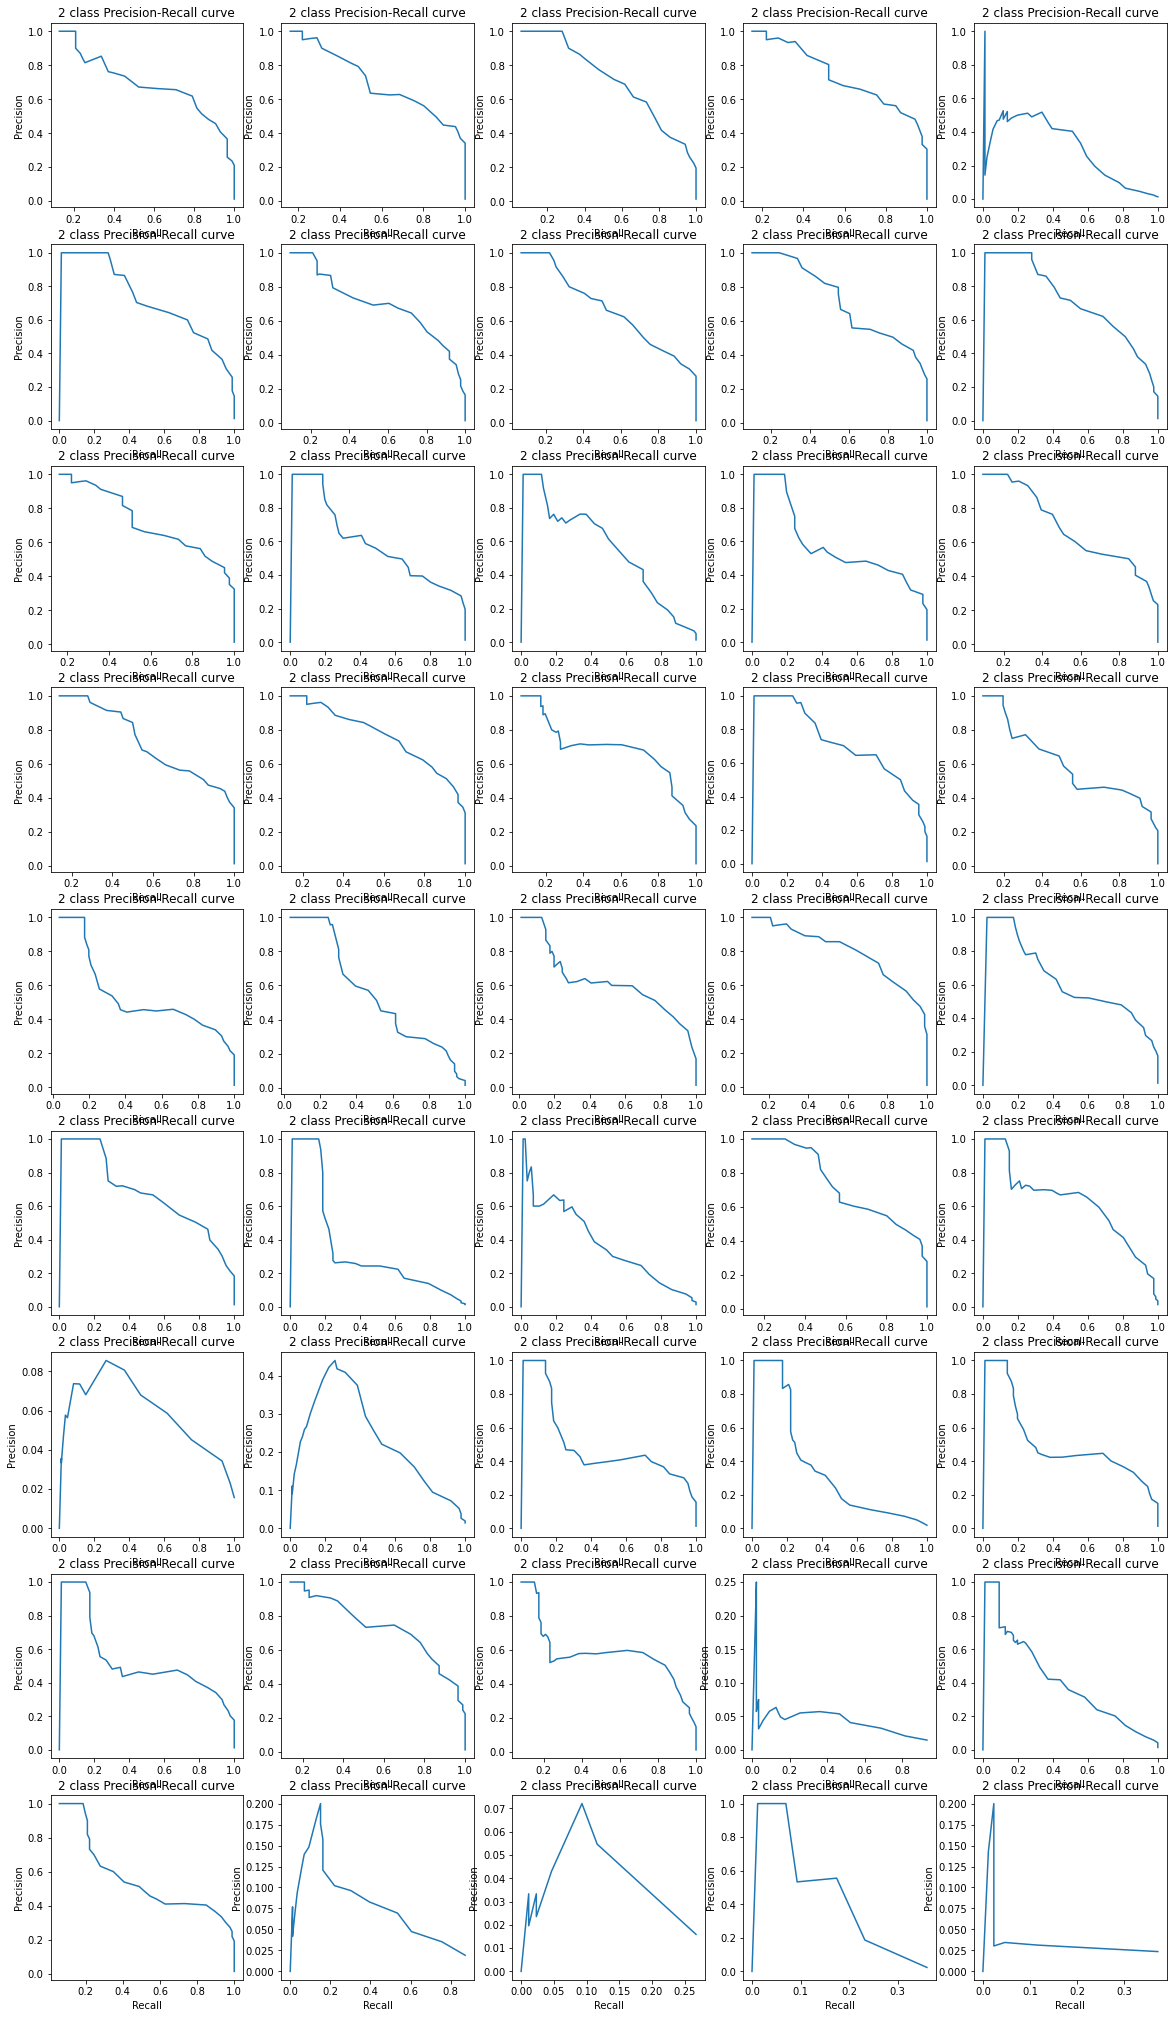

In [676]:
printCurve(rec_score_list, prc_score_list, "2 class Precision-Recall curve", "Recall", "Precision")

In [677]:
for best_model_index in range(len(model_list)):
    print(F"model {best_model_index} training loss = {history_list[best_model_index].history['loss'][-1]}")
    print(F"model {best_model_index} validation loss = {history_list[best_model_index].history['val_loss'][-1]}")

model 0 training loss = 0.6381809831683685
model 0 validation loss = 0.660937702195948
model 1 training loss = 0.7372839347210408
model 1 validation loss = 0.763896437581433
model 2 training loss = 0.46663474638335906
model 2 validation loss = 0.47337048976322993
model 3 training loss = 0.509899571969639
model 3 validation loss = 0.5223984573822031
model 4 training loss = 0.49446470885771826
model 4 validation loss = 0.49808547672358705
model 5 training loss = 0.4514786663469718
model 5 validation loss = 0.45949394473902855
model 6 training loss = 0.4713358351879481
model 6 validation loss = 0.48862419559027076
model 7 training loss = 0.46858028665458046
model 7 validation loss = 0.48404319902415904
model 8 training loss = 0.38025674357045275
model 8 validation loss = 0.3830456494988115
model 9 training loss = 0.3651677183488741
model 9 validation loss = 0.35292975033725843
model 10 training loss = 0.5105144605171649
model 10 validation loss = 0.5493481956172042
model 11 training loss 

In [679]:
best_model_index = 23
model_list[best_model_index].summary()
print(F"model {best_model_index} training loss = {history_list[best_model_index].history['loss'][-1]}")
print(F"model {best_model_index} validation loss = {history_list[best_model_index].history['val_loss'][-1]}")

Model: "sequential_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_892 (Dense)            (None, 9)                 117       
_________________________________________________________________
dense_893 (Dense)            (None, 4)                 40        
_________________________________________________________________
dense_894 (Dense)            (None, 9)                 45        
_________________________________________________________________
dense_895 (Dense)            (None, 12)                120       
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________
model 23 training loss = 0.24536789551714316
model 23 validation loss = 0.2695083530001872


In [680]:
model = model_list[best_model_index]
history = history_list[best_model_index]

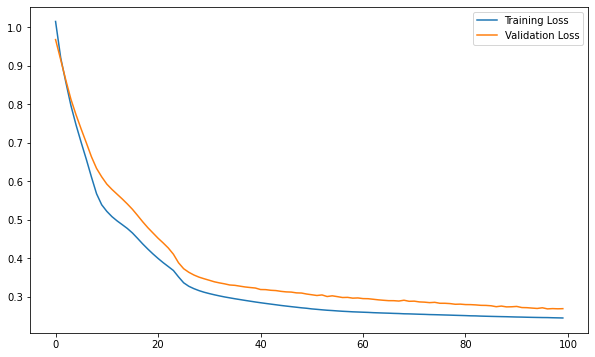

In [681]:
# print the loss with epochs
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [682]:
pred1 = model.predict(X_testing)
score1 = np.sqrt(metrics.mean_squared_error(pred1,X_testing))
print(f"Test smaples Score (RMSE): {score1}")

Test smaples Score (RMSE): 0.5153639566837286


In [683]:
# this dataframe shows the difference between the actural pm2.5 and the reconstructed pm2.5
df_diff = X_testing[:, 0] - pred1[:, 0]

diff = np.absolute(df_diff)
# df_diff = df_diff.values

In [684]:
# actural numbers of anomaly data classified by the "rule" we set
true_tag = testing_data_tag

In [685]:
df_diff.shape

(10296,)

In [686]:
threshold = np.arange(0.1, 6, 0.1)
rec_score = np.zeros(len(threshold))
# pred_tag = np.zeros(len(threshold))
prc_score = np.zeros(len(threshold))

In [687]:
diff.shape

(10296,)

In [688]:
for i in range(len(threshold)):
    pred_tag = (diff >= threshold[i])
    rec_score[i] = sklearn.metrics.recall_score(true_tag, pred_tag)
    prc_score[i] = sklearn.metrics.precision_score(true_tag, pred_tag)
    pred_tag = np.zeros(len(threshold))

In [689]:
def printCuv(x, y, title, xlabel, ylabel):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)

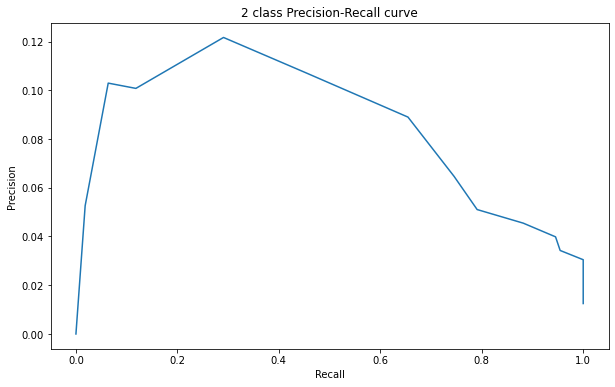

In [690]:
printCuv(rec_score, prc_score, "2 class Precision-Recall curve", "Recall", "Precision")

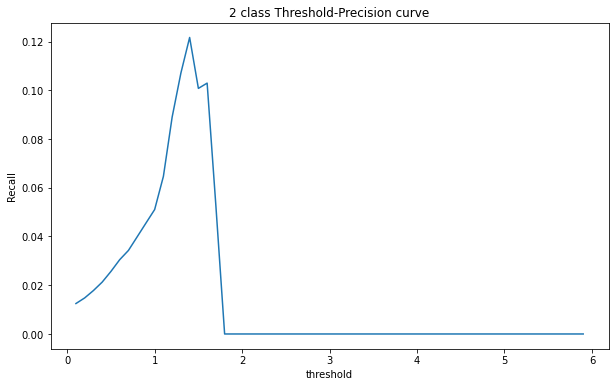

In [691]:
printCuv(threshold, prc_score, "2 class Threshold-Precision curve", "threshold", "Recall")

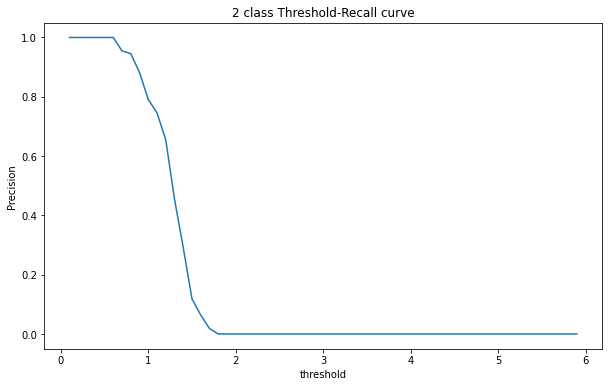

In [692]:
printCuv(threshold, rec_score, "2 class Threshold-Recall curve", "threshold", "Precision")